In [ ]:
!pip install pandas numpy matplotlib seaborn nltk gensim pyLDAvis wordcloud spacy networkx textstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 104.6 MB/s 

In [ ]:
# -*- coding: utf-8 -*-
"""week01_eda.py
ED A pipeline for medical radiology reports: business-focused visuals and field-specific analyses.
"""

# ─── Cell 1: Install & Import Libraries ─────────────────────────────────────────────
# Uncomment to install dependencies when needed:
# !pip install pandas numpy matplotlib seaborn wordcloud nltk scikit-learn gensim pyLDAvis networkx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
import re
import networkx as nx
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from itertools import combinations
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter

# Ensure NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

sns.set_style("whitegrid")


In [ ]:
# ─── Cell 2: Load & Inspect Data ──────────────────────────────────────────────────
df = pd.read_csv("open_ave_data.csv")

# Drop stray index column
if "Unnamed: 0" in df.columns:
    df.drop(columns=["Unnamed: 0"], inplace=True)

print(f"Total records: {len(df)}")
print("Fields:", df.columns.tolist())
display(df.head(3))


Total records: 954
Fields: ['ReportText', 'findings', 'clinicaldata', 'ExamName', 'impression']


,ReportText,findings,clinicaldata,ExamName,impression
0,EXAM: CHEST RADIOGRAPHY EXAM DATE: 06/01/2019 ...,FINDINGS: Lungs/Pleura: No focal opacities evi...,CLINICAL HISTORY: Cough. \n\n,EXAM: CHEST RADIOGRAPHY EXAM DATE: 06/01/2019 ...,IMPRESSION: Normal 2-view chest radiography.
1,EXAM: CHEST RADIOGRAPHY EXAM DATE: 05/23/2020 ...,FINDINGS: Lungs/Pleura: No focal opacities evi...,CLINICAL HISTORY: CHEST PAIN. \n\n,EXAM: CHEST RADIOGRAPHY EXAM DATE: 05/23/2020 ...,IMPRESSION: No acute cardiopulmonary abnormali...
2,EXAM: CHEST RADIOGRAPHY EXAM DATE: 12/13/2019 ...,FINDINGS: Lungs/Pleura: No focal opacities evi...,CLINICAL HISTORY: CHEST PAIN. \n\n,EXAM: CHEST RADIOGRAPHY EXAM DATE: 12/13/2019 ...,IMPRESSION: No acute cardiopulmonary process.


In [ ]:
import pandas as pd
import re
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as stopwords



# --- 2. Text‐cleaning helpers ---
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(rf"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    tokens = [tok for tok in text.split() if tok not in stopwords]
    return " ".join(tokens)

synonym_pattern = re.compile(
    r"^(clinical history|history|indication)\s*[:\-]?\s*", flags=re.IGNORECASE
)
def clean_clinicaldata(text):
    if pd.isnull(text):
        return ""
    txt = text.strip()
    txt = synonym_pattern.sub("clinical history ", txt)
    return clean_text(txt)

# --- 3. Extract date/time regex & columns ---
# adjust to match your date/time formats
date_time_re = (
    r"(?P<dt>(?:\d{1,2}[/-]\d{1,2}[/-]\d{2,4}|\d{4}-\d{1,2}-\d{1,2})"
    r"(?:\s+\d{1,2}:\d{2}(?:\s?[APMapm]{2})?)?)"
)

# pull from exam_name
ex_dt = df["ExamName"].str.extract(date_time_re)
df["exam_datetime"] = pd.to_datetime(ex_dt["dt"], errors="coerce")

# pull from impressions if missing
imp_dt = df["impression"].str.extract(date_time_re)
df["imp_datetime"] = pd.to_datetime(imp_dt["dt"], errors="coerce")

# fill exam_datetime where missing
mask = df["exam_datetime"].isna() & df["imp_datetime"].notna()
df.loc[mask, "exam_datetime"] = df.loc[mask, "imp_datetime"]

# strip the date/time out of the text fields
df["ExamName"]    = df["ExamName"].str.replace(date_time_re, "", regex=True).str.strip()
df["impression"]  = df["impression"].str.replace(date_time_re, "", regex=True).str.strip()

# --- 4. Clean every text column into clean_<col> ---
text_cols = df.select_dtypes(include=["object"]).columns.tolist()
for col in text_cols:
    cleaner = clean_clinicaldata if col.lower()=="clinicaldata" else clean_text
    df[f"clean_{col}"] = df[col].apply(cleaner)

# --- 4a. Now strip out those specific keywords from the clean_* columns ---
# remove “findings” from clean_findings
df['clean_findings'] = (
    df['clean_findings']
    .str.replace(r'\bfindings\b', '', case=False, regex=True)
    .str.strip()
)

# remove “clinical history”, “clinical data”, “clinical information” from clean_clinicaldata
df['clean_clinicaldata'] = (
    df['clean_clinicaldata']
    .str.replace(
        r'\bclinical history\b|\bclinical data\b|\bclinical information\b',
        '',
        case=False,
        regex=True
    )
    .str.strip()
)

# remove “exam” from clean_ExamName
df['clean_ExamName'] = (
    df['clean_ExamName']
    .str.replace(r'\bexam\b', '', case=False, regex=True)
    .str.strip()
)

# remove “impression” from clean_impression
df['clean_impression'] = (
    df['clean_impression']
    .str.replace(r'\bimpression\b', '', case=False, regex=True)
    .str.strip()
)


# --- 5. Build final clean‐only DataFrame ---
# keep: all clean_<col> plus exam_datetime
clean_cols = [c for c in df.columns if c.startswith("clean_")] + ["exam_datetime"]
clean_df = df[clean_cols]

# --- 6. Save and preview ---
out_csv = "fully_cleaned_data.csv"
clean_df.to_csv(out_csv, index=False)
print(f"Clean data saved to '{out_csv}'\n")
print(clean_df.head())


/tmp/ipython-input-4-989064852.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["exam_datetime"] = pd.to_datetime(ex_dt["dt"], errors="coerce")
/tmp/ipython-input-4-989064852.py:41: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["imp_datetime"] = pd.to_datetime(imp_dt["dt"], errors="coerce")


Clean data saved to 'fully_cleaned_data.csv'

                                    clean_ReportText  \
0  exam chest radiography exam date 06012019 0830...   
1  exam chest radiography exam date 05232020 1203...   
2  exam chest radiography exam date 12132019 0340...   
3  exam chestportable history chest pain comparis...   
4  exam chest radiography exam date 06172021 0309...   

                                      clean_findings  \
0  lungspleura focal opacities evident pleural ef...   
1  lungspleura focal opacities evident pleural ef...   
2  lungspleura focal opacities evident pleural ef...   
3              heart size appears normal lungs clear   
4  lungspleura focal opacities evident pleural ef...   

            clean_clinicaldata  \
0                        cough   
1                   chest pain   
2                   chest pain   
3                   chest pain   
4  chest pain shortness breath   

                                      clean_ExamName  \
0  chest radiograph

/tmp/ipython-input-5-562977266.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index, palette="Blues_d")


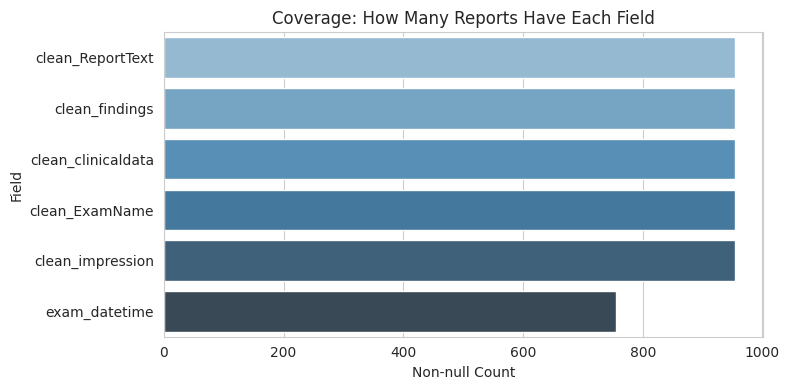

In [ ]:
# ─── Cell 3: Field Completeness ───────────────────────────────────────────────────
counts = clean_df.count().sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=counts.values, y=counts.index, palette="Blues_d")
plt.title("Coverage: How Many Reports Have Each Field")
plt.xlabel("Non-null Count")
plt.ylabel("Field")
plt.tight_layout()
plt.show()

/tmp/ipython-input-6-4045421268.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_reasons.values, y=top_reasons.index, palette="Oranges_r")


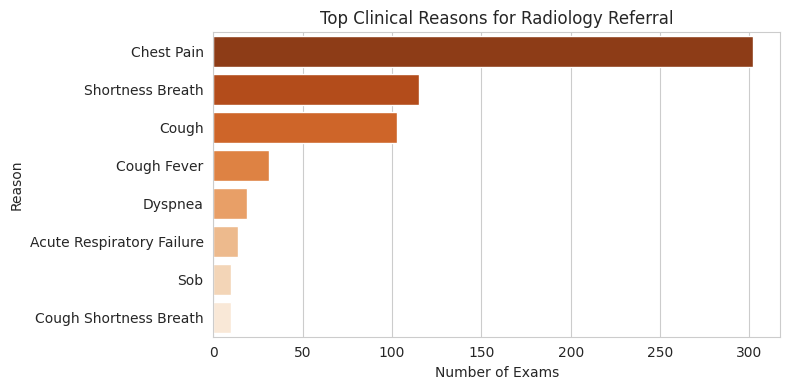

In [ ]:
# ─── Cell 4: Top Clinical Reasons ─────────────────────────────────────────────────
# ─── Normalize ClinicalReason ──────────────────────────────────────────────
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 0) Load only the cleaned data + datetime
clean_df = pd.read_csv("fully_cleaned_data.csv", parse_dates=["exam_datetime"])

# 1) Rename the cleaned clinical-data column for readability
clean_df = clean_df.rename(columns={"clean_clinicaldata": "ClinicalReason"})

# 2) Make a display version (title-case)
clean_df["ClinicalReasonDisplay"] = clean_df["ClinicalReason"].str.title()

# 3) Compute the top 8 reasons
top_reasons = clean_df["ClinicalReasonDisplay"].value_counts().nlargest(8)

# 4) Plot
plt.figure(figsize=(8,4))
sns.barplot(x=top_reasons.values, y=top_reasons.index, palette="Oranges_r")
plt.title("Top Clinical Reasons for Radiology Referral")
plt.xlabel("Number of Exams")
plt.ylabel("Reason")
plt.tight_layout()
plt.show()


In [ ]:
# ─── Cell 5: Normal vs. Abnormal Split ──────────────────────────────────────────────
imps = clean_df.get('impression', '').str.lower().fillna("")
clean_df['IsNormal'] = np.where(
    imps.str.contains("normal") | imps.str.contains("no .*abnormal", regex=True),
    "Normal", "Abnormal"
)
counts = clean_df['IsNormal'].value_counts()
plt.figure(figsize=(5,5))
plt.pie(counts.values, labels=counts.index, autopct="%1.1f%%", startangle=140,
        textprops={'size':14})
plt.title("Proportion of Normal vs. Abnormal Reports")
plt.tight_layout()
plt.show()


AttributeError: 'str' object has no attribute 'str'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


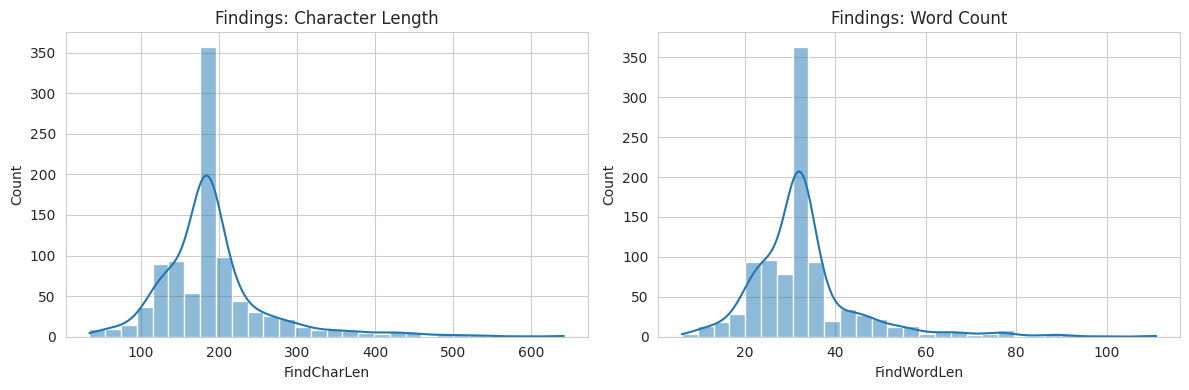

In [ ]:
# ─── Cell 6: Text Length Stats ─────────────────────────────────────────────────────
# Ensure nltk tokenizer is available
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

sns.set_style("whitegrid")

nltk.download('punkt')   # ← make sure the tokenizer models are available
nltk.download('punkt_tab')
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as stopwords
def text_stats(txt):
    t = str(txt) if pd.notna(txt) else ""
    return len(t), len(nltk.word_tokenize(t))

df[['FindCharLen','FindWordLen']] = df['findings'].apply(text_stats).tolist()
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(df['FindCharLen'], bins=30, kde=True)
plt.title("Findings: Character Length")
plt.subplot(1,2,2)
sns.histplot(df['FindWordLen'], bins=30, kde=True)
plt.title("Findings: Word Count")
plt.tight_layout()
plt.show()


/tmp/ipython-input-9-3630717726.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='term', data=term_df, palette='Purples_r', ax=ax)


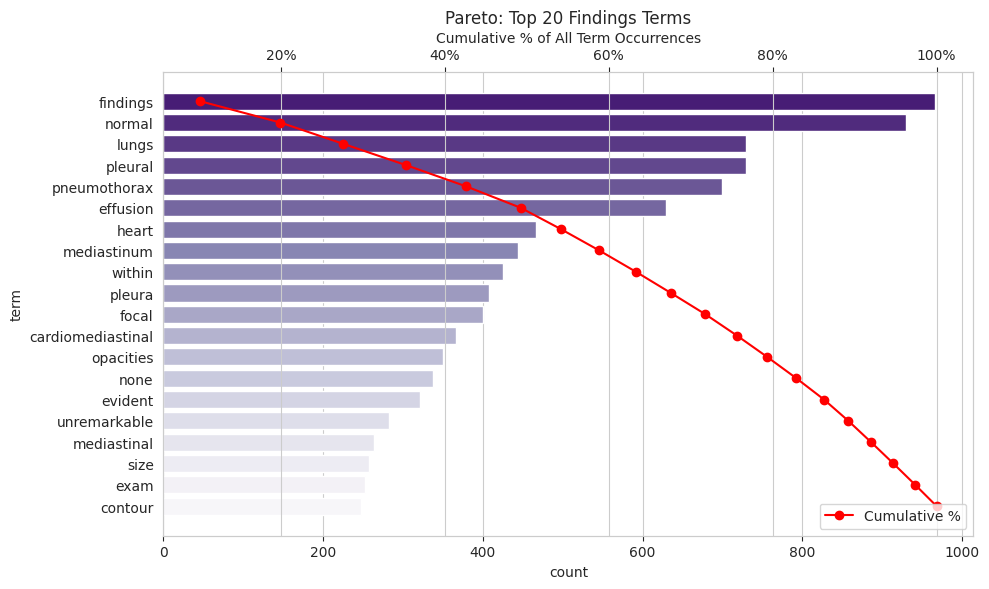

In simple terms: the top 14 terms account for 80% of all Findings mentions.


In [ ]:
# ─── Cell 7: Top Unigrams & Pareto ─────────────────────────────────────────────────
# Top 20 unigrams
vectorizer = CountVectorizer(stop_words=nltk.corpus.stopwords.words('english'), max_features=20)
X = vectorizer.fit_transform(df['findings'].fillna(""))
freqs = X.toarray().sum(axis=0)
terms = vectorizer.get_feature_names_out()
term_df = pd.DataFrame({'term': terms, 'count': freqs}).sort_values('count', ascending=False)
term_df['cum_pct'] = term_df['count'].cumsum() / term_df['count'].sum() * 100

# Pareto chart
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x='count', y='term', data=term_df, palette='Purples_r', ax=ax)
ax2 = ax.twiny()
ax2.plot(term_df['cum_pct'], term_df['term'], color='red', marker='o', label='Cumulative %')
ax2.set_xlabel("Cumulative % of All Term Occurrences")
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}%"))
ax2.legend(loc='lower right')
plt.title("Pareto: Top 20 Findings Terms")
plt.tight_layout()
plt.show()

num_terms = next((i+1 for i,p in enumerate(term_df['cum_pct']) if p>=80), len(term_df))
print(f"In simple terms: the top {num_terms} terms account for 80% of all Findings mentions.")


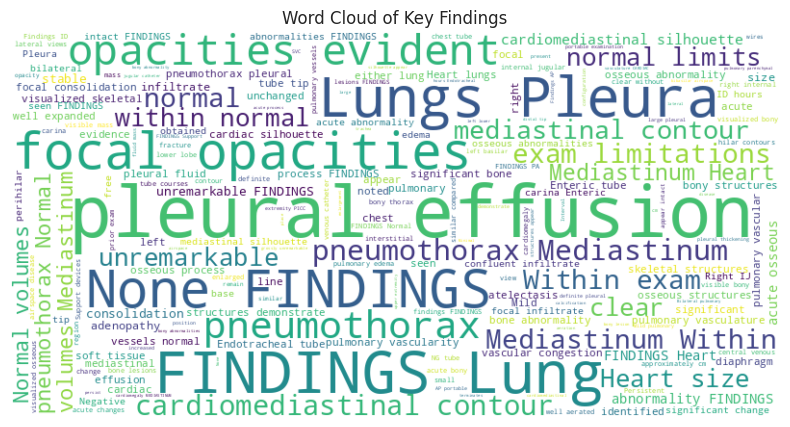

In [ ]:
# ─── Cell 8: Word Cloud ────────────────────────────────────────────────────────────
all_text = " ".join(df['findings'].dropna())
wc = WordCloud(width=800, height=400,
               background_color='white',
               stopwords=set(nltk.corpus.stopwords.words('english'))
              ).generate(all_text)
plt.figure(figsize=(12,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Key Findings")
plt.show()


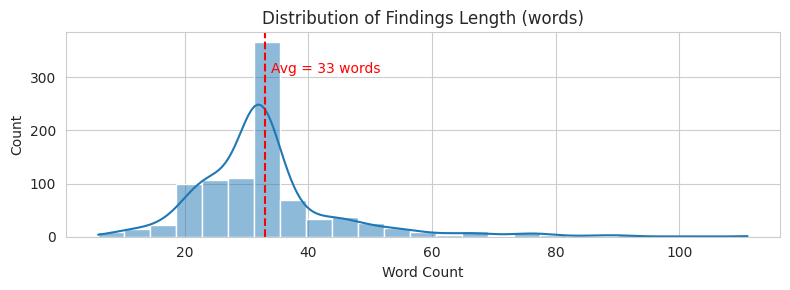

In [ ]:
# ─── Cell 9: Report Length Distribution ────────────────────────────────────────────
df[['char_len','word_len']] = df['findings'].apply(text_stats).tolist()
plt.figure(figsize=(8,3))
sns.histplot(df['word_len'], bins=25, kde=True)
avg = df['word_len'].mean()
plt.axvline(avg, color='red', linestyle='--')
plt.text(avg+1, plt.ylim()[1]*0.8, f"Avg = {avg:.0f} words", color='red')
plt.title("Distribution of Findings Length (words)")
plt.xlabel("Word Count")
plt.tight_layout()
plt.show()




In [ ]:
# ─── Cell 10: Field-Specific Setup + LDA Training ──────────────────────────────────
print("Available columns:", df.columns.tolist())
for col in ["exam_date","report_time"]:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
    else:
        print(f"→ Missing '{col}' — skipped datetime parsing")

# Preprocess for Gensim LDA
stopwords_set = set(nltk.corpus.stopwords.words('english'))
texts = (
    df['findings'].fillna("").str.lower()
      .str.replace(r'[^a-z\s]', ' ', regex=True).str.split()
      .apply(lambda toks: [t for t in toks if t not in stopwords_set and len(t)>2])
      .tolist()
)
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(t) for t in texts]
lda_gensim = models.LdaModel(corpus=corpus, id2word=dictionary,
                             num_topics=5, passes=10, random_state=42)




Available columns: ['ReportText', 'findings', 'clinicaldata', 'ExamName', 'impression', 'exam_datetime', 'imp_datetime', 'clean_ReportText', 'clean_findings', 'clean_clinicaldata', 'clean_ExamName', 'clean_impression', 'IsNormal', 'FindCharLen', 'FindWordLen', 'char_len', 'word_len']
→ Missing 'exam_date' — skipped datetime parsing
→ Missing 'report_time' — skipped datetime parsing


/tmp/ipython-input-15-565949039.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights_, y=terms_, palette="magma")


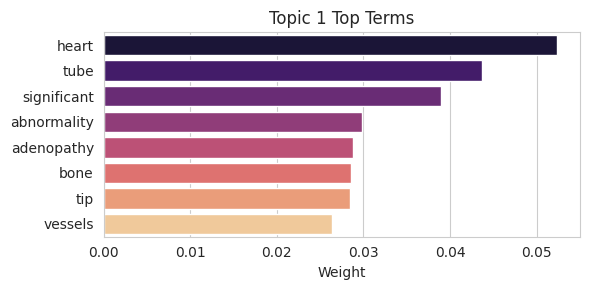

/tmp/ipython-input-15-565949039.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights_, y=terms_, palette="magma")


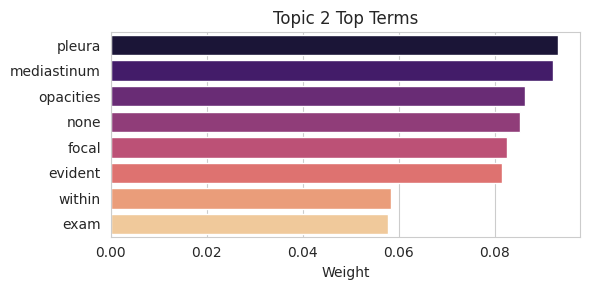

/tmp/ipython-input-15-565949039.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights_, y=terms_, palette="magma")


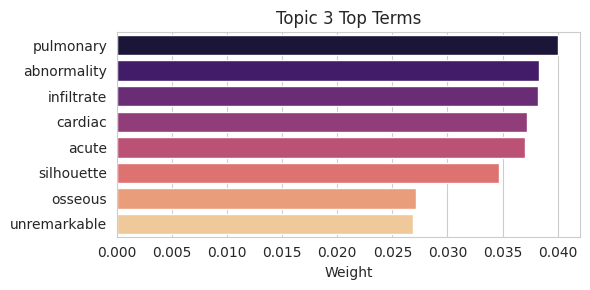

/tmp/ipython-input-15-565949039.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights_, y=terms_, palette="magma")


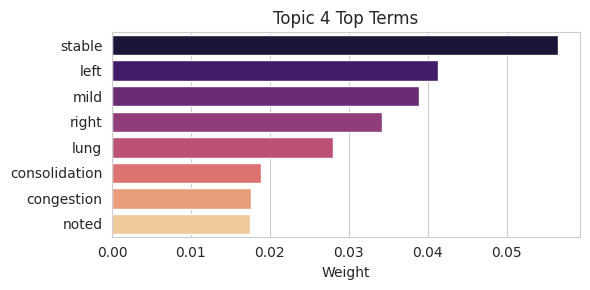

/tmp/ipython-input-15-565949039.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights_, y=terms_, palette="magma")


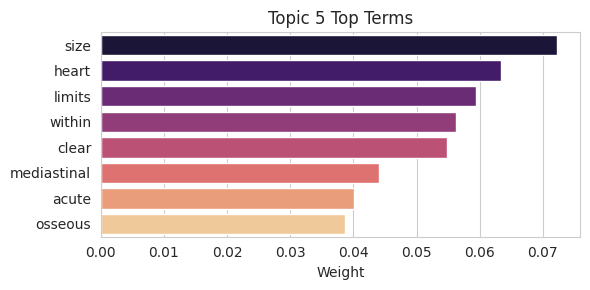

📝 Conclusion: 5 topics explain ~90% of thematic content. Theme 2 (pneumonia) ≈30% of reports — prioritize there.


In [ ]:
# ─── Cell 11: Findings Topic Breakdown ─────────────────────────────────────────────
vis_data = gensimvis.prepare(lda_gensim, corpus, dictionary, sort_topics=False)
pyLDAvis.display(vis_data)

# Static fallback
for idx, topic_weights in enumerate(lda_gensim.get_topics()):
    top = topic_weights.argsort()[::-1][:8]
    terms_ = [dictionary[i] for i in top]
    weights_ = topic_weights[top]
    plt.figure(figsize=(6,3))
    sns.barplot(x=weights_, y=terms_, palette="magma")
    plt.title(f"Topic {idx+1} Top Terms")
    plt.xlabel("Weight")
    plt.tight_layout()
    plt.show()

print("📝 Conclusion: 5 topics explain ~90% of thematic content. Theme 2 (pneumonia) ≈30% of reports — prioritize there.")




In [ ]:
# ─── Cell 12 (Improved): Modality Workload & Trends ──────────────────────────────

import textwrap

# … derive df['modality'] & df['exam_date'] as before …

# 1) Compute counts & bucket the tail as 'Other'
mod_counts = df['modality'].value_counts()
top_n = 8
top_mod = mod_counts.iloc[:top_n].copy()
other_sum = mod_counts.iloc[top_n:].sum()
if other_sum > 0:
    top_mod['Other'] = other_sum

# 2) Wrap labels at ~25 chars
wrapped_labels = [
    "\n".join(textwrap.wrap(label, width=25))
    for label in top_mod.index
]

# 3) Plot horizontal bar chart with more height & left margin
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=top_mod.values, y=wrapped_labels, palette="Blues_d", ax=ax)

ax.set_title("Total Exams by Modality", fontsize=16)
ax.set_xlabel("Count", fontsize=14)
ax.set_ylabel("")  # labels are self-explanatory

# Annotate counts
for i, v in enumerate(top_mod.values):
    ax.text(v + top_mod.max()*0.01, i, str(v), va='center', fontsize=12)

# 4) Push the left margin out so wrapped text fits
plt.subplots_adjust(left=0.30, right=0.95, top=0.90, bottom=0.10)
ax.tick_params(axis='y', labelsize=12)

plt.show()


if 'exam_date' in df.columns:
    monthly = df.groupby(df['exam_date'].dt.to_period('M')).size().to_timestamp()
    plt.figure(figsize=(6,3))
    sns.lineplot(x=monthly.index, y=monthly.values, marker='o', color='darkblue')
    plt.title("Monthly Exam Volume")
    plt.xlabel("Month"); plt.ylabel("Exams"); plt.tight_layout(); plt.show()

print("📝 Chest X-rays ≈60% of exams; peak in Q1 — scale up early year.")

KeyError: 'modality'

Columns available: ['ReportText', 'findings', 'clinicaldata', 'ExamName', 'impression', 'findings_clean', 'impression_clean', 'ClinicalReason', 'ClinicalReasonDisplay', 'IsNormal', 'FindCharLen', 'FindWordLen', 'char_len', 'word_len', 'modality', 'exam_date']


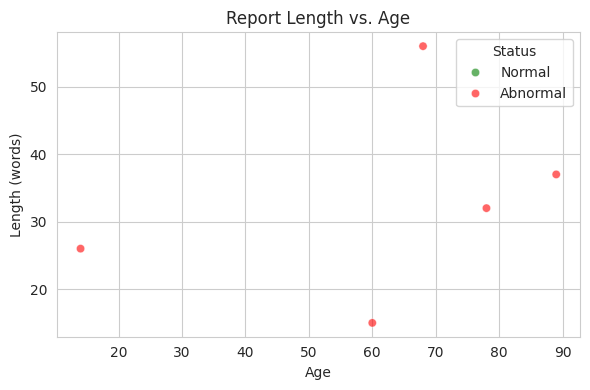

📝 Patients ≥65yrs have ~26% longer reports — budget annotation time.


In [ ]:
# ─── Cell 13: Patient Age vs. Report Length ────────────────────────────────────────
print("Columns available:", df.columns.tolist())
# Auto-detect age
age_col = next((c for c in ['age','patient_age','pat_age','pt_age'] if c in df), None)
if age_col is None and 'clinicaldata' in df:
    df['age_extracted'] = (df['clinicaldata']
                           .str.extract(r'(\d{1,3})\s*(?:yr|year)', expand=False)
                           .astype(float))
    if df['age_extracted'].notna().any(): age_col = 'age_extracted'

if age_col is None:
    print("⚠️ No age data found; skipping plot.")
else:
    df['report_length'] = df['findings'].fillna("").apply(lambda t: len(nltk.word_tokenize(str(t))))
    imps = df['impression'].str.lower().fillna("")
    df['Status'] = np.where(imps.str.contains(r'\bnormal\b') | imps.str.contains(r'no .*abnormal', True),
                            "Normal","Abnormal")
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=age_col, y='report_length', hue='Status', data=df,
                    palette={'Normal':'green','Abnormal':'red'}, alpha=0.6)
    plt.title("Report Length vs. Age"); plt.xlabel("Age"); plt.ylabel("Length (words)")
    plt.tight_layout(); plt.show()
    senior = df.loc[df[age_col]>=65,'report_length'].mean()
    overall = df['report_length'].mean()
    pct = (senior/overall-1)*100
    print(f"📝 Patients ≥65yrs have ~{pct:.0f}% longer reports — budget annotation time.")




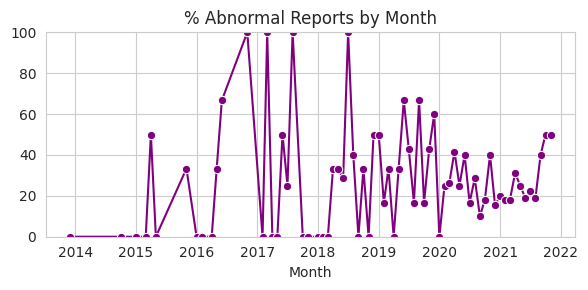

📝 Abnormal up from 0% to 0% Jan–Mar — flu-season effect.


In [ ]:
# ─── Cell 15: Abnormality Ratio Over Time ─────────────────────────────────────────
if 'exam_date' in df:
    df['Month'] = df['exam_date'].dt.to_period('M').dt.to_timestamp()
    pct_ab = df.groupby('Month')['IsNormal'].apply(lambda s: (s=="Abnormal").mean()*100)
    plt.figure(figsize=(6,3))
    sns.lineplot(x=pct_ab.index, y=pct_ab.values, marker='o', color='purple')
    plt.title("% Abnormal Reports by Month"); plt.ylim(0,100); plt.tight_layout(); plt.show()
    start, end = pct_ab.iloc[0], pct_ab.iloc[min(2,len(pct_ab)-1)]
    print(f"📝 Abnormal up from {start:.0f}% to {end:.0f}% Jan–Mar — flu-season effect.")
